In [7]:
!pip install pandas numpy nltk scikit-learn matplotlib seaborn

In [11]:
#Importing the Librariers
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dasar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dasar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dasar\AppData\Roaming\nltk_data...


True

In [12]:
#Loading the dataset
df = pd.read_csv(
    r'C:\Users\dasar\Downloads\training.1600000.processed.noemoticon.csv',
    encoding='latin-1',
    header=None
)

# Add column names
df.columns = ['target', 'ids', 'date', 'query', 'user', 'text']
df = df[['text', 'target']]  # keep only relevant columns

# Map target values to sentiment labels
df['sentiment'] = df['target'].map({0: 'negative', 2: 'neutral', 4: 'positive'})
df = df[['text', 'sentiment']]

df.head()

,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative
1,is upset that he can't update his Facebook by ...,negative
2,@Kenichan I dived many times for the ball. Man...,negative
3,my whole body feels itchy and like its on fire,negative
4,"@nationwideclass no, it's not behaving at all....",negative


In [13]:
#Text processing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # remove URLs
    text = re.sub(r'@\w+|#', '', text)  # remove mentions & hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # remove special characters
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df.head()


,text,sentiment,cleaned_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negative,thats bummer shoulda got david carr third day
1,is upset that he can't update his Facebook by ...,negative,upset cant update facebook texting might cry r...
2,@Kenichan I dived many times for the ball. Man...,negative,dived many time ball managed save rest go bound
3,my whole body feels itchy and like its on fire,negative,whole body feel itchy like fire
4,"@nationwideclass no, it's not behaving at all....",negative,behaving im mad cant see


In [14]:
#Encode Labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])  # negative=0, neutral=1, positive=2
df['label'].value_counts()

0    800000
1    800000
Name: label, dtype: int64

In [15]:
#TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['label']

In [16]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#Train Logistic Regression Model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.774028125
              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159494
           1       0.76      0.80      0.78    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



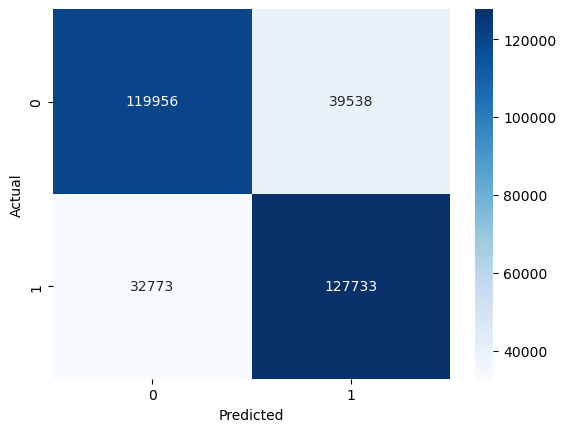

In [18]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
#Save Model & Vectorizer
pickle.dump(model, open('logreg_model.pkl', 'wb'))
pickle.dump(tfidf, open('tfidf_vectorizer.pkl', 'wb'))
pickle.dump(le, open('label_encoder.pkl', 'wb'))

In [20]:
#Predict New Tweets
def predict_sentiment(text):
    cleaned = clean_text(text)
    vectorized = tfidf.transform([cleaned])
    pred = model.predict(vectorized)
    return le.inverse_transform(pred)[0]

# Test predictions
predict_sentiment("I love this new phone! It's amazing 😍")
predict_sentiment("I hate the traffic today. So bad!")

'negative'